# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *
import statsmodels.api as sm

# Define the FarmEnv class
# class FarmEnv:
#     def __init__(self, farm: Farm, reward_function=None):
#         self.game = farm  # Accept a Farm instance directly
#         self.done = False
#         self.reward_function = reward_function or self.default_reward

#     def reset(self):
#         self.game = configure_game()  # Reset the game
#         self.done = False
#         return self.get_state()

#     def step(self, action):
#         current_player = self.game.whose_turn()["name"]
#         self.game = self.game.take_action(action, inplace=True)  # Apply action
#         reward = self.reward_function(self.game, current_player)  # Calculate reward
#         self.done = self.game.is_done()  # Check if game is done
#         new_state = self.get_state()  # Get the updated state
#         return new_state, reward, self.done, {}  # Return updated state

#     def get_state(self):
#         return self.map

#     def render(self):
#         self.game.print_farm()

#     def default_reward(self, game, player):
#         return game.playersDict[player]["score"]

# Training

In [2]:
#score used throughout, reward used at end?

In [3]:
class QLearningAgent:
    def __init__(self, learning_rate, discount_factor, epsilon, color, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.color = color

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        Assuming 'state' is an object with properties that can be converted to hashable types.
        """
        # Example: Convert agent positions and other attributes to tuples
        if self.color == "red":
            player = state.redplayer
        else:
            player = state.purpleplayer
#         agents = tuple((player['loc']['x'], player['loc']['y'], player['name']))
#         energy_levels = player['energy']
#         items = tuple((item.loc['x'], item.loc['y'], item.color) for item in state.items)
#         backpacks = tuple((player['backpack']['capacity'], len(player['backpack']['contents'])))
        agents = tuple((player['loc']['x'], player['loc']['y']))
        energy_levels = player['energy']
        #items = tuple((item.loc['x'], item.loc['y']) for item in state.items if item.color == self.color and item.status == "farm")
        #backpacks = player['backpack']['capacity']- len(player['backpack']['contents'])
        

        return (agents, energy_levels)

    def get_action_representation(self, action):
        return (action.type, action.color)  # Simplified action representation
#         if action.type == ActionType.veggie:
#             if action.color == state.whose_turn()['color']:
#                 action_type = 1
#         if action.type == ActionType.box:
#             action_type = 2
#         else: action_type = -1
#         return (action_type)  # Simplified action representation


    def get_q_value(self, state, action):
        state_rep = self.get_state_representation(state)
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        actions = self.current_state.legal_actions()
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            return random.choice(actions)

        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        return random.choice(best_actions)

    def update_q_value(self, action, reward, next_state):
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        next_actions = next_state.legal_actions()
        #max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)
        max_q_next = max([self.get_q_value(next_state, a) for a in next_actions], default=0)

        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

    def decay_epsilon(self, decay_rate=0.99):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

def train_q_learning_agent(env, learning_rate, discount_factor, epsilon, num_episodes, max_steps_per_episode=100):
    agent1 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color = "red")
    agent2 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color = "purple")

    final_rewards_red = []
    final_rewards_purple = []
    helpful_moves_red = []
    helpful_moves_purple = []

    for episode in range(num_episodes):
        state = farmgame.configure_game(layer="Simple",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0
        purple_helpful_count = 0

        for step in range(max_steps_per_episode):
            if state.redplayer['loc']['x'] >= 5 or state.redplayer['loc']['y'] >= 5:
                print(state.redplayer['loc'])
            if state.purpleplayer['loc']['x'] >= 5 or state.purpleplayer['loc']['y'] >= 5:
                print(state.purpleplayer['loc'])
            
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            reward1, done = next_state.reward("red")
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break

            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break

        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")
        print(red_rwd, purple_rwd)
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        agent1.decay_epsilon()
        agent2.decay_epsilon()

        if (episode + 1) % 100 == 0:
            avg_red_reward = sum(final_rewards_red[-100:]) / 100
            avg_purple_reward = sum(final_rewards_purple[-100:]) / 100
            print(f"Episode {episode + 1}: Avg Red Reward = {avg_red_reward}, Avg Purple Reward = {avg_purple_reward}")
            print(f"Avg Helpful Moves: Red = {sum(helpful_moves_red[-100:]) / 100}, Purple = {sum(helpful_moves_purple[-100:]) / 100}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple

TheFarm = farmgame.configure_game(layer="Simple",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
state = TheFarm

done = False
learning_rate = 0.3
discount_factor = 0.9
epsilon = 0.8
agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(TheFarm, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, num_episodes=5000)

### Recommendations:
# 2. **Reward Function**: Double-check that rewards align with desired behaviors.
# 3. **Adjust Parameters**: Experiment with higher learning rates and lower discount factors.
# 4. **Exploration**: Monitor and adjust epsilon decay to ensure sufficient exploration.

# By following these recommendations and tweaks, your RL agent should learn more effectively. Let me know if you have more questions or need further assistance! 😊

2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
Episode 100: Avg Red Reward = 2.0, Avg Purple Reward = 2.0
Avg Helpful Moves: Red = 1.19, Purple = 0.98
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
Episode 200: Avg Red Reward = 2.0, Avg Purple Reward = 2.0
Avg Helpful Moves: Red = 1.09, Purple

2 2
0 1
1 0
Episode 1800: Avg Red Reward = 1.45, Avg Purple Reward = 1.2
Avg Helpful Moves: Red = 1.09, Purple = 1.02
1 1
2 2
2 1
1 2
2 2
2 1
0 2
2 2
2 2
2 2
2 2
1 2
2 1
2 2
2 2
2 2
2 2
1 2
1 2
1 1
2 2
2 2
1 0
2 2
2 1
2 2
2 0
0 0
2 2
2 2
0 0
2 2
2 2
0 0
0 1
2 2
2 2
1 2
2 0
2 0
0 0
2 2
2 2
1 1
0 0
2 1
2 1
2 2
2 2
2 2
2 2
2 1
2 1
2 2
2 2
2 2
2 2
1 2
2 2
2 2
2 2
2 1
2 2
2 1
2 2
1 1
2 2
1 2
2 2
2 2
2 2
2 2
2 2
2 2
0 0
2 0
1 1
1 0
2 2
0 2
2 2
2 2
0 1
2 1
2 1
2 2
1 0
2 1
2 2
1 1
1 2
2 2
2 0
2 1
2 2
2 2
2 2
2 2
2 2
2 1
Episode 1900: Avg Red Reward = 1.63, Avg Purple Reward = 1.49
Avg Helpful Moves: Red = 1.14, Purple = 1.0
2 2
1 2
1 2
2 2
1 2
1 2
2 0
2 2
2 1
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 0
2 2
1 1
2 1
2 2
0 0
1 2
2 2
2 0
1 1
1 0
2 2
2 2
2 2
2 0
2 1
0 0
2 1
2 0
2 2
1 2
2 2
1 1
2 2
2 2
2 2
2 2
0 0
2 1
2 2
2 1
2 0
1 1
2 2
2 2
2 2
2 0
1 1
1 0
2 2
1 1
1 0
2 2
1 2
1 2
2 2
1 0
2 2
0 0
1 0
2 1
2 1
2 1
1 0
1 0
0 0
2 0
2 2
2 2
2 1
1 0
1 2
1 0
2 2
2 2
1 1
2 2
2 2
1 0
0 0
0 0
1 0
2 1
2 2
2 2
2 2


2 0
2 2
1 2
1 2
2 1
2 2
2 1
2 1
2 2
1 1
2 1
2 2
2 2
0 1
0 1
0 0
1 2
2 2
2 1
1 1
1 1
2 1
1 0
2 2
1 1
2 1
1 2
2 2
2 2
2 1
2 1
2 2
2 1
2 1
2 0
2 2
2 1
0 0
2 2
1 1
2 2
2 1
2 2
2 1
1 0
2 2
2 2
2 2
0 2
1 0
0 0
2 1
1 1
2 0
2 2
2 1
1 2
2 2
0 2
0 0
2 1
2 2
2 1
2 1
2 1
2 1
2 2
2 2
1 2
1 0
1 0
2 2
1 2
1 1
2 2
2 1
2 2
1 0
2 1
1 0
2 2
2 2
2 2
2 0
2 2
1 2
Episode 3500: Avg Red Reward = 1.59, Avg Purple Reward = 1.34
Avg Helpful Moves: Red = 1.06, Purple = 0.99
2 2
2 2
2 2
0 0
1 1
2 2
1 2
1 1
1 0
2 0
2 2
2 2
2 2
1 0
2 1
2 2
2 2
2 2
2 0
1 1
2 2
2 2
2 1
1 1
1 1
2 2
2 2
1 0
1 0
2 2
2 2
2 2
2 0
1 0
1 2
1 2
0 0
2 2
2 2
1 1
1 1
2 2
2 2
2 2
1 1
1 0
2 2
1 1
2 2
2 2
2 0
2 2
1 2
2 0
2 2
0 1
2 2
2 2
2 1
0 0
2 0
2 2
2 2
2 1
2 1
2 0
2 2
2 2
1 2
0 1
2 2
2 0
1 1
2 2
2 0
2 2
2 2
1 2
2 2
2 2
2 2
1 2
2 1
1 1
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 1
2 1
2 1
1 2
1 0
2 2
2 1
2 1
2 0
Episode 3600: Avg Red Reward = 1.64, Avg Purple Reward = 1.36
Avg Helpful Moves: Red = 0.93, Purple = 0.92
2 2
1 0
2 2
1 0
2 2
2 2
2 1
2 0
2 2
1 0
1 

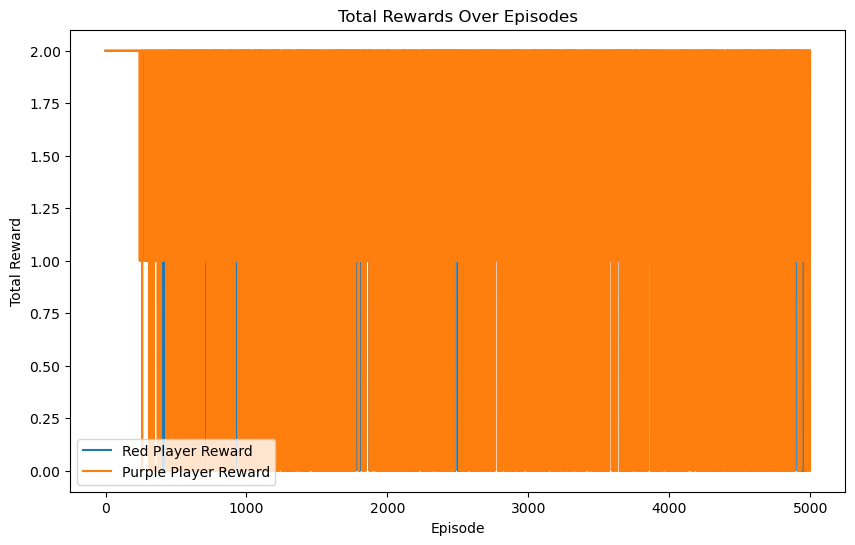

-2.529580901183476e-05
-5.812387432495706e-05


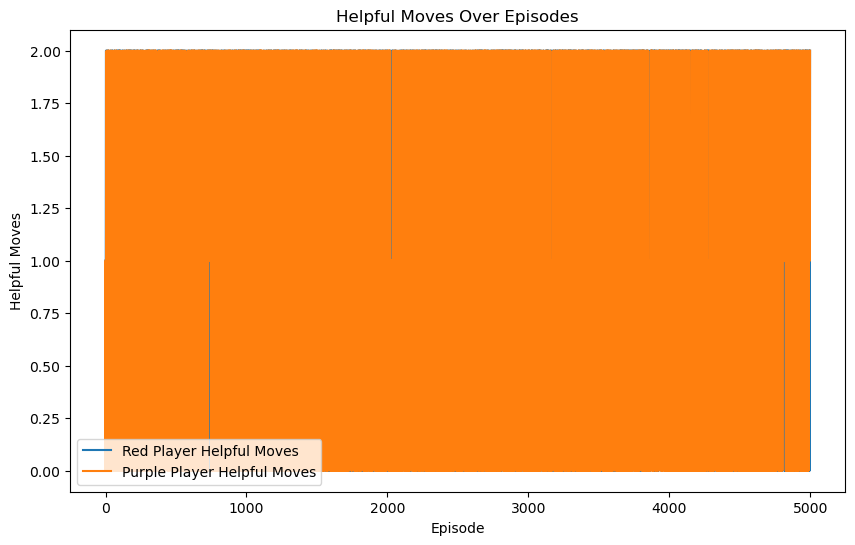

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()
# Generate x values (indices of the original values)
x = np.arange(len(final_rewards_red))

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_red, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_purple, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


In [5]:
def OLS(values):
    # Generate x values (indices of the original values)
    x = np.arange(len(values))

    # Add a constant to the independent variables matrix for the intercept
    X = sm.add_constant(x)

    # Fit the linear regression model
    model = sm.OLS(values, X)
    results = model.fit()

    # Print the summary
    print(results.summary())

    # Extract slope and its confidence interval
    slope = results.params[1]
    slope_ci = results.conf_int()[1]
    print(f"Slope: {slope}, 95% Confidence Interval: {slope_ci}")

    # Plot the original values
    plt.plot(values, 'o', label='Original values')

    # Plot the line of best fit
    plt.plot(x, results.predict(X), '-', label='Line of Best Fit')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Trend of Values with Line of Best Fit')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
total_reward = np.array(final_rewards_red)+np.array(final_rewards_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     49.70
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           2.03e-12
Time:                        16:10:02   Log-Likelihood:                -8037.2
No. Observations:                5000   AIC:                         1.608e+04
Df Residuals:                    4998   BIC:                         1.609e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1125      0.034     91.134      0.0

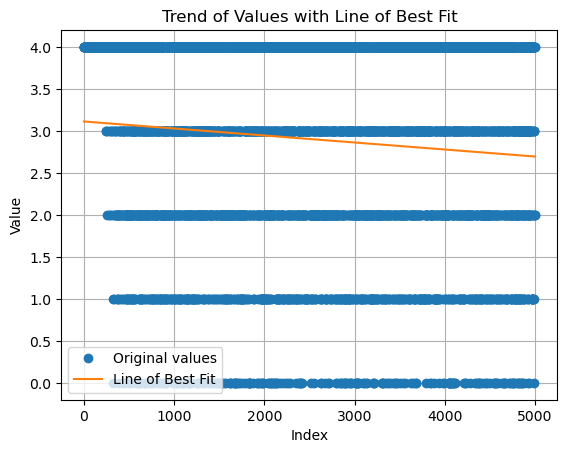

In [7]:
OLS(total_reward)

In [11]:
total_reward[0:1000].mean(),total_reward[-1000:].mean()

(175.886, 128.746)

In [12]:
#Seeing learning!

In [13]:
all_helping = np.array(helpful_moves_red)+np.array(helpful_moves_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.244
Date:                Thu, 12 Dec 2024   Prob (F-statistic):             0.0717
Time:                        16:06:58   Log-Likelihood:                -8251.8
No. Observations:                5000   AIC:                         1.651e+04
Df Residuals:                    4998   BIC:                         1.652e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0360      0.036     57.109      0.0

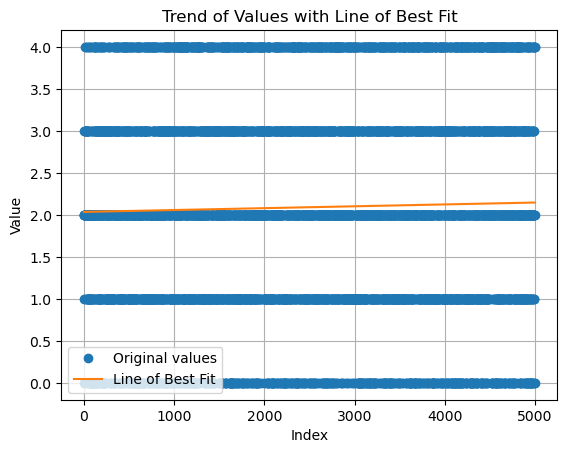

In [14]:
OLS(all_helping)

# walking through step by step 

### setup

In [8]:
agent1 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2, color = "red")
agent2 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2, color = "purple")

final_rewards_red = []  # To store the final rewards of the 'red' player
final_rewards_purple = []  # To store the final rewards of the 'purple' player
helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

#state = env.reset()  # Reset the environment for a new episode
state = farmgame.configure_game(layer="Simple",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)

#done = False

In [9]:
state.redplayer

{'loc': {'x': 1, 'y': 1},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [10]:
state.purpleplayer

{'loc': {'x': 4, 'y': 4},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [11]:
state = farmgame.configure_game(layer="Simple",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
agent1.update(state)
agent2.update(state)

red_helpful_count = 0  # Counter for red's helpful moves
purple_helpful_count = 0  # Counter for purple's helpful moves


### Red takes a step

In [12]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state

In [13]:
state.redplayer

{'loc': {'x': 2, 'y': 1},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x17a0a7290>],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x17a0a7290>]},
 'score': 0,
 'energy': 99,
 'bonuspoints': 10,
 'has_helped': False}

In [14]:
state.redplayer['backpack']['contents'][0].color

'red'

In [15]:
## so red slept, same spot

In [16]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state

In [17]:
state.purpleplayer

{'loc': {'x': 4, 'y': 4},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 95,
 'bonuspoints': 0,
 'has_helped': False}

In [18]:
state.purpleplayer['backpack']['contents'][0].color

'red'

In [109]:
# We see purple moved to turnip, but why does it have same backpack capacity
#We see it has backpack content now. So it should be picked up and capacity has not been updated



In [19]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state
state.redplayer

{'loc': {'x': 4, 'y': 2},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x17a0a7290>,
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x17a0a7290>,
   <farmgame.Action at 0x17a2037d0>]},
 'score': 0,
 'energy': 96,
 'bonuspoints': 10,
 'has_helped': True}

In [20]:
state.redplayer['backpack']['contents'][1].color

'purple'

In [21]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state
state.purpleplayer

{'loc': {'x': 4, 'y': 4},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 90,
 'bonuspoints': 0,
 'has_helped': False}

In [26]:
state.all_objects_picked_up('purple')

AttributeError: 'Farm' object has no attribute 'all_objects_picked_up'

In [ ]:
#now it should have two things in the backpack? Only 1?
#why is the location the same if it went to eggplant?
